In [21]:
import pandas as pd
import numpy as np
import pickle
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


In [22]:
with open("Data/train_test_split_revisited.pkl", "rb") as f:
    X_train, X_test, y_train, y_test = pickle.load(f)

In [23]:
# Replace infinities with NaN
X_train.replace([np.inf, -np.inf], np.nan, inplace=True)
X_test.replace([np.inf, -np.inf], np.nan, inplace=True)

# Fill NaNs with median of each column
for col in numeric_features:
    median = X_train[col].median()
    X_train[col].fillna(median, inplace=True)
    X_test[col].fillna(median, inplace=True)



In [24]:
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# -----------------------------
# 1️⃣ Define features
# -----------------------------
numeric_features = ['Car_Age', 'Mileage_per_Year', 'Engine', 'Brand_Strength']  # add 'Remaining_Life' if you kept it
binary_features = ['Has_Service_History', 'Is_Premium', 'Is_Family_Car']
categorical_features = [col for col in X_train.columns if col not in numeric_features + binary_features + ['Log_Price']]

# -----------------------------
# 2️⃣ Preprocessor
# -----------------------------
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),   # optional, RF does not need scaling
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ],
    remainder='passthrough'  # leave binary columns as is
)

# -----------------------------
# 3️⃣ Build pipeline
# -----------------------------
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(random_state=42))
])

# -----------------------------
# 4️⃣ Hyperparameter grid
# -----------------------------
param_grid = {
    'regressor__n_estimators': [200, 500, 800],
    'regressor__max_depth': [None, 20, 25],
    'regressor__min_samples_split': [2, 5, 10],
    'regressor__min_samples_leaf': [1, 2, 4],
    'regressor__max_features': ['sqrt', 0.5, 0.7]
}

# -----------------------------
# 5️⃣ Randomized Search
# -----------------------------
scoring = {
    'R2':'r2',
    'MAE':'neg_mean_absolute_error',
    'RMSE':'neg_root_mean_squared_error'
}

random_search = RandomizedSearchCV(
    pipeline,
    param_distributions=param_grid,
    n_iter=50,
    cv=5,
    scoring=scoring,
    refit='R2',
    n_jobs=-1,
    verbose=1,
    random_state=42
)

# -----------------------------
# 6️⃣ Fit model
# -----------------------------
random_search.fit(X_train, y_train)

print("Best params:", random_search.best_params_)
print("Train R²:", random_search.score(X_train, y_train))
print("Test R²:", random_search.score(X_test, y_test))

# -----------------------------
# 7️⃣ Predict and evaluate in £
# -----------------------------
y_pred_log = random_search.predict(X_test)
y_test_actual = np.exp(y_test)
y_pred_actual = np.exp(y_pred_log)

rmse = np.sqrt(mean_squared_error(y_test_actual, y_pred_actual))
mae = mean_absolute_error(y_test_actual, y_pred_actual)
r2 = r2_score(y_test_actual, y_pred_actual)

print("RMSE (£):", rmse)
print("MAE (£):", mae)
print("R²:", r2)


Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best params: {'regressor__n_estimators': 800, 'regressor__min_samples_split': 2, 'regressor__min_samples_leaf': 1, 'regressor__max_features': 0.7, 'regressor__max_depth': 20}
Train R²: 0.9853116675342399
Test R²: 0.8739340341865218
RMSE (£): 1340.0137857252557
MAE (£): 770.2602978678395
R²: 0.9156614907016334


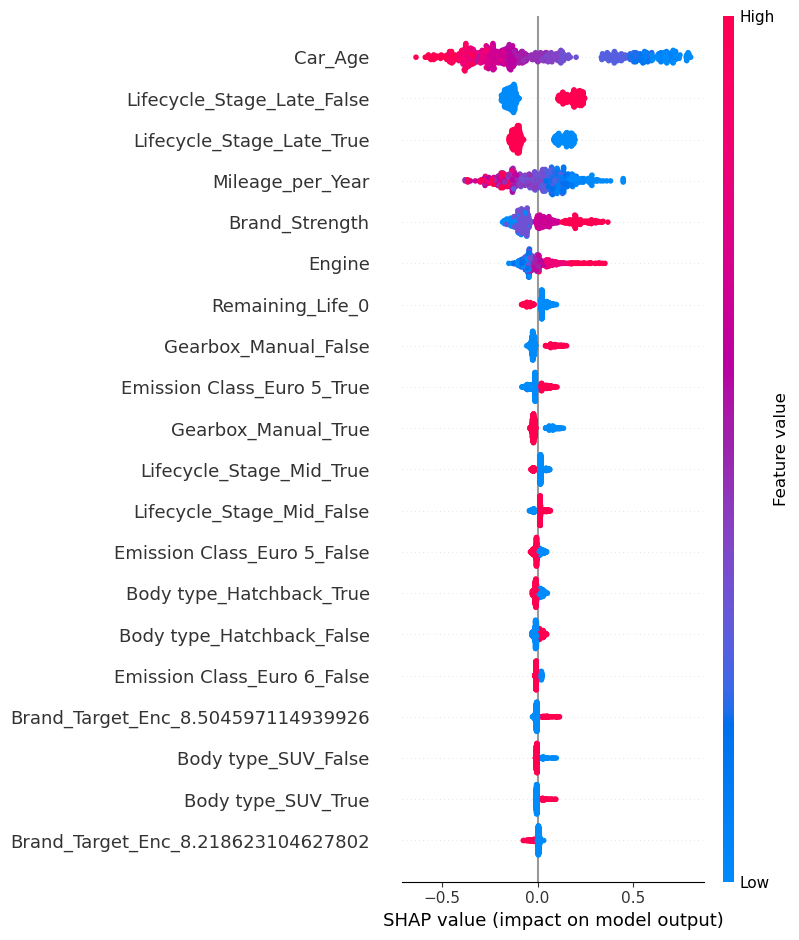

In [26]:
# -----------------------------
# Get fitted pipeline and regressor
# -----------------------------
best_pipeline = random_search.best_estimator_

# Preprocess test data
X_test_preprocessed = best_pipeline.named_steps['preprocessor'].transform(X_test)

# Get trained Random Forest
rf_model = best_pipeline.named_steps['regressor']

# -----------------------------
# SHAP explainer
# -----------------------------
import shap
explainer = shap.TreeExplainer(rf_model)
shap_values = explainer.shap_values(X_test_preprocessed)
import pandas as pd

# Numeric features
numeric_features = ['Car_Age', 'Mileage_per_Year', 'Engine', 'Brand_Strength']

# Get ColumnTransformer
preprocessor = best_pipeline.named_steps['preprocessor']

# Get the categorical transformer from ColumnTransformer
# It might be directly OneHotEncoder
categorical_transformer = preprocessor.named_transformers_['cat']

# Get categorical feature names
# If you used OneHotEncoder directly (not a pipeline), do:
categorical_features = categorical_transformer.get_feature_names_out(preprocessor.transformers_[1][2])  
# preprocessor.transformers_[1][2] gives original categorical column names

# Combine numeric + categorical feature names
feature_names = list(numeric_features) + list(categorical_features)

# Convert preprocessed test set to DataFrame
X_test_preprocessed_df = pd.DataFrame(X_test_preprocessed, columns=feature_names)


# -----------------------------
# SHAP summary plot
# -----------------------------
import matplotlib.pyplot as plt

shap.summary_plot(shap_values, X_test_preprocessed, feature_names=feature_names, max_display=20)


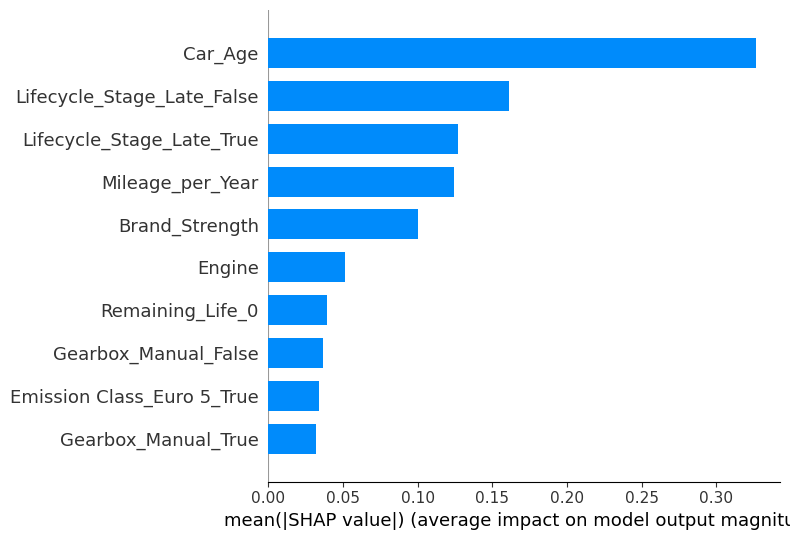

In [27]:
shap.summary_plot(
    shap_values, 
    X_test_preprocessed_df, 
    feature_names=feature_names,
    max_display=10,       # show top 10 features only
    plot_type='bar',      # bar plot for clear ranking
    color_bar=True
)

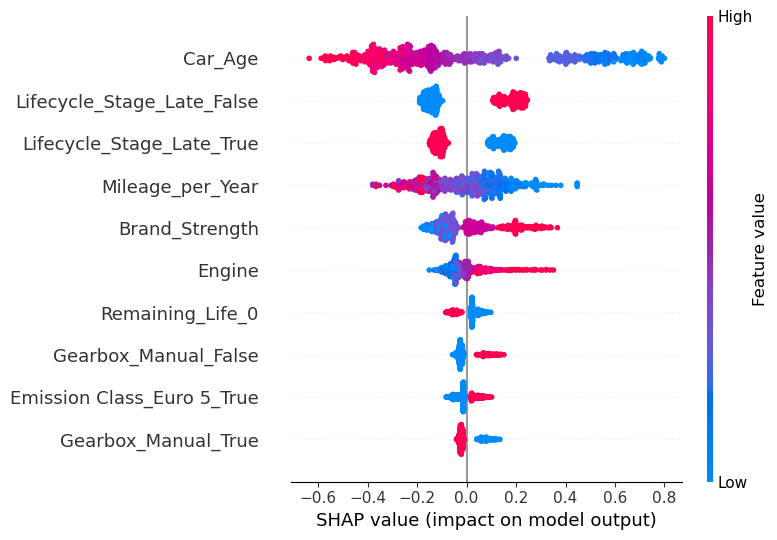

In [28]:

# Create dot-style summary plot
shap.summary_plot(
    shap_values, 
    X_test_preprocessed_df, 
    feature_names=feature_names,
    max_display=10,       # top 10 features
    plot_type='dot'       # dot plot shows positive/negative effect
)